In [1]:
!pip install openpyxl
!pip install d2l==1.0.3
!pip install "gpytorch"

In [2]:
import math
import os
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix
from scipy.special import ndtri
from d2l import torch as d2l
import pandas as pd

d2l.set_figsize()

Loading the training and test data. They are from the same base dataset and the training data is every odd numbered datapoint while the test data is every even numbered data point. 

In [3]:
train_data = pd.read_excel(r'C:\Users\miklo\OneDrive\UQ\gauss process\1d_test\train_data.xlsx', header=None)
train_x = train_data.iloc[:, 0].to_numpy()
train_y = train_data.iloc[:, 1].to_numpy()

test_data = pd.read_excel(r'C:\Users\miklo\OneDrive\UQ\gauss process\1d_test\test_data.xlsx', header=None)
test_x = test_data.iloc[:, 0].to_numpy()
test_y = test_data.iloc[:, 1].to_numpy()

print("train_x:", train_x)
print("train_y:", train_y)
print("test_x:", test_x)
print("test_y:", test_y)

y_mean = np.mean(train_y)
y_std = np.std(train_y)


train_x: [   1    3    5    7    9   11   13   15   17   19   21   23   25   27
   29   31   33   35   37   39   41   43   45   47   49   51   53   55
   57   59   61   63   65   67   69   71   73   75   77   79   81   83
   85   87   89   91   93   95   97   99  101  103  105  107  109  111
  113  115  117  119  121  123  125  127  129  131  133  135  137  139
  141  143  145  147  149  151  153  155  157  159  161  163  165  167
  169  171  173  175  177  179  181  183  185  187  189  191  193  195
  197  199  201  203  205  207  209  211  213  215  217  219  221  223
  225  227  229  231  233  235  237  239  241  243  245  247  249  251
  253  255  257  259  261  263  265  267  269  271  273  275  277  279
  281  283  285  287  289  291  293  295  297  299  301  303  305  307
  309  311  313  315  317  319  321  323  325  327  329  331  333  335
  337  339  341  343  345  347  349  351  353  355  357  359  361  363
  365  367  369  371  373  375  377  379  381  383  385  387  389  3

In [4]:
#converting and normalizing the data

print(y_mean, "is the mean and ",y_std, "is the standard deviation I normalized with.")
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)


train_x = train_x.clone().detach()
test_y = (test_y.clone().detach() - y_mean) / y_std
train_y = (train_y.clone().detach() - y_mean) / y_std
test_x = test_x.clone().detach()




domain = np.linspace(-100, 1900, 17610)
domain = torch.tensor(domain, dtype=torch.float32)


8651.980703745743 is the mean and  719.9087001263094 is the standard deviation I normalized with.


In [5]:



#+gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.ConstantKernel()

# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Initialize Gaussian likelihood



likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 1000

#model.covar_module.base_kernel.kernels[0].lengthscale = torch.tensor(5.0)

model.covar_module.base_kernel.kernels[1].register_constraint("raw_period_length", gpytorch.constraints.Interval(52.1, 52.2)) #the period is constrained


# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 100 == 0:
        print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f} '
              #f'squared lengthscale: '
              #f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'RBF kernel lengthscale: {model.covar_module.base_kernel.kernels[0].lengthscale.item():.3f} '
              f'Periodic kernel period length: {model.covar_module.base_kernel.kernels[1].period_length.item():.3f} '
              f'Perdiodic kernel lengthscale: {model.covar_module.base_kernel.kernels[1].lengthscale.item():.3f} '
              f'Noise variance: {model.likelihood.noise.item():.3f}')
     
        
    optimizer.step()


Iter 1/1000 - Loss: 1.426 RBF kernel lengthscale: 0.693 Periodic kernel period length: 52.150 Perdiodic kernel lengthscale: 0.693 Noise variance: 0.693
Iter 101/1000 - Loss: 0.820 RBF kernel lengthscale: 4.208 Periodic kernel period length: 52.116 Perdiodic kernel lengthscale: 0.367 Noise variance: 0.116
Iter 201/1000 - Loss: 0.726 RBF kernel lengthscale: 6.185 Periodic kernel period length: 52.161 Perdiodic kernel lengthscale: 0.089 Noise variance: 0.110
Iter 301/1000 - Loss: 0.716 RBF kernel lengthscale: 7.125 Periodic kernel period length: 52.146 Perdiodic kernel lengthscale: 0.131 Noise variance: 0.116
Iter 401/1000 - Loss: 0.694 RBF kernel lengthscale: 7.728 Periodic kernel period length: 52.146 Perdiodic kernel lengthscale: 0.142 Noise variance: 0.117
Iter 501/1000 - Loss: 0.705 RBF kernel lengthscale: 8.268 Periodic kernel period length: 52.138 Perdiodic kernel lengthscale: 0.127 Noise variance: 0.121
Iter 601/1000 - Loss: 0.681 RBF kernel lengthscale: 8.885 Periodic kernel peri

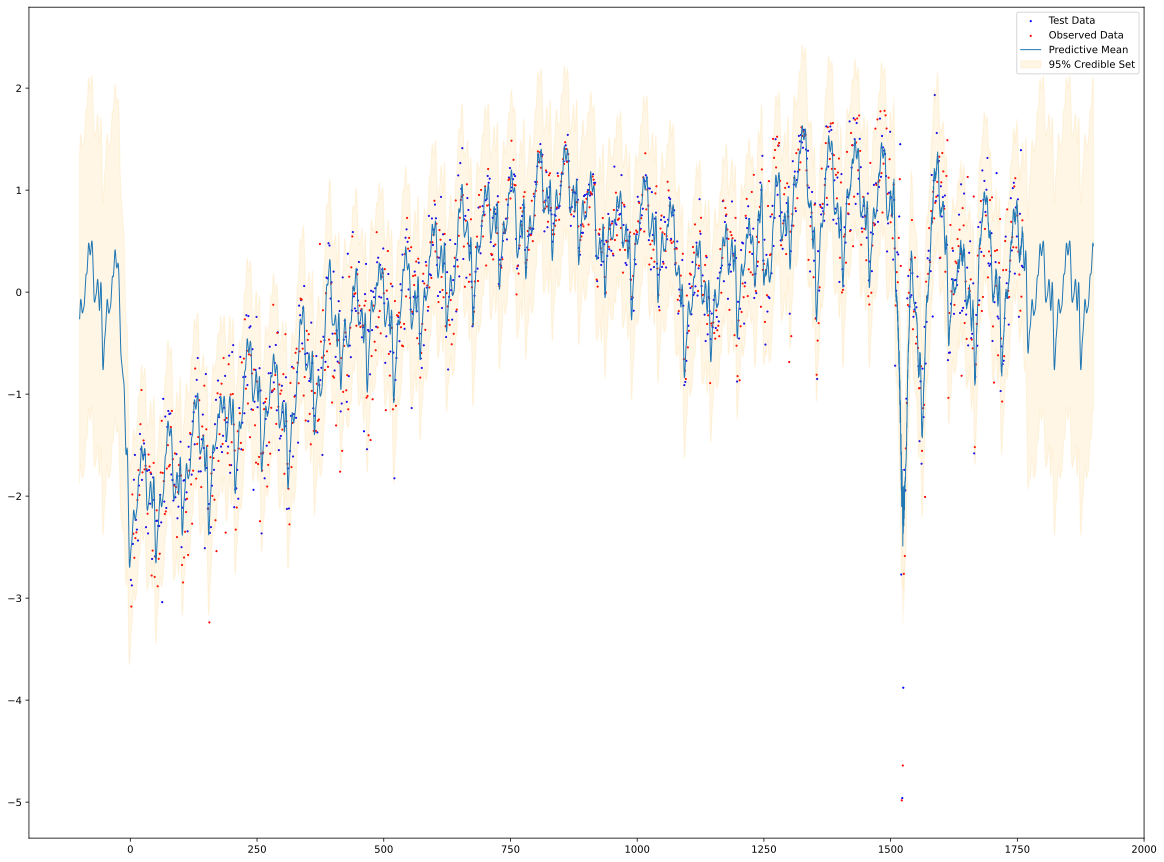

In [6]:

model.eval()
likelihood.eval()
observed_pred = likelihood(model(domain))
observed_pred_test=likelihood(model(test_x))

with torch.no_grad():
   
    f, ax = d2l.plt.subplots(1, 1, figsize=(20, 15))

    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy(), s=1.5, color='blue')
    ax.scatter(test_x.numpy(), test_y.numpy(), s=1.5, color='red')
    ax.plot(domain.numpy(), observed_pred.mean.numpy(), linewidth=1)
    ax.fill_between(domain.numpy(), lower.numpy(), upper.numpy(), alpha=0.1, color='orange')
    #ax.set_ylim([-1.5, 1.5])
    ax.legend(['Test Data', 'Observed Data','Predictive Mean','95% Credible Set'])

In [7]:
#probability that each test value is within it's confidence interval
lower_test, upper_test = observed_pred_test.confidence_region()

difference=test_y-observed_pred_test.mean
std_2=upper_test-observed_pred_test.mean
standardized=difference*2/std_2

#detach for calculations

#difference_np = difference.detach().numpy()
#std_2_np = std_2.detach().numpy()
standardized_np = standardized.detach().numpy()



std_normal = torch.distributions.Normal(0, 1)
prob=1-std_normal.cdf(torch.abs(standardized))+std_normal.cdf(-torch.abs(standardized))
print("prob that it is at most that far: ", prob)
print("standardized numpy", standardized_np)






prob that it is at most that far:  tensor([1.5460e-01, 3.4260e-01, 5.9714e-01, 2.8678e-01, 6.4801e-01, 6.2266e-01,
        9.5629e-01, 8.0725e-01, 6.1399e-01, 3.2631e-01, 1.6429e-01, 6.7391e-01,
        6.5136e-01, 6.1049e-01, 9.0800e-01, 4.7785e-01, 9.2341e-01, 2.2303e-01,
        5.0826e-01, 8.2230e-01, 5.8545e-02, 2.4387e-01, 7.1919e-01, 9.2634e-02,
        9.2971e-01, 3.3273e-01, 1.7230e-01, 3.1770e-01, 1.6207e-01, 5.0028e-01,
        3.2635e-02, 5.0547e-01, 8.5480e-01, 2.1166e-01, 1.5537e-01, 5.1474e-01,
        5.5961e-01, 3.5867e-01, 4.6689e-01, 9.7497e-01, 4.4399e-01, 5.7316e-01,
        7.3105e-01, 2.9666e-01, 9.8192e-01, 1.0758e-01, 8.8258e-01, 5.2997e-01,
        8.0075e-01, 8.6915e-01, 4.1567e-01, 1.2851e-01, 1.5610e-01, 2.7388e-01,
        2.5781e-01, 4.5398e-01, 5.8444e-02, 9.1492e-01, 3.9045e-01, 3.3312e-01,
        2.9097e-02, 2.5674e-01, 9.7008e-01, 3.6564e-01, 7.7826e-02, 2.2575e-01,
        3.6790e-01, 3.7032e-01, 9.3119e-01, 3.5851e-01, 6.5523e-01, 9.9628e-01,
     

c:\Users\miklo\.conda\envs\d2l\lib\site-packages\matplotlib\patches.py:738: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)
c:\Users\miklo\.conda\envs\d2l\lib\site-packages\matplotlib\transforms.py:2049: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


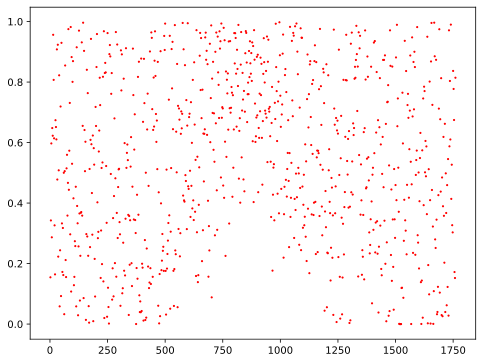

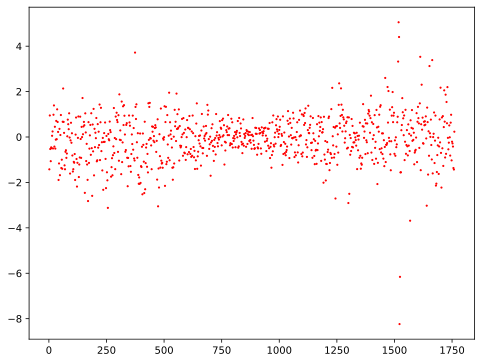

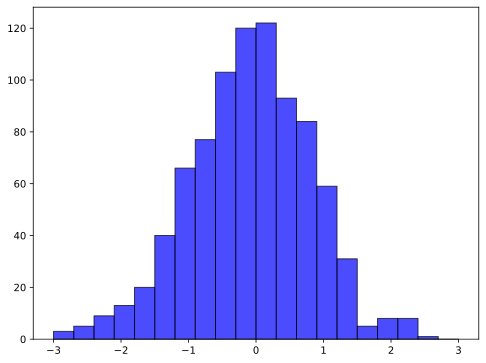

In [8]:
with torch.no_grad():
   
    f, ax1 = d2l.plt.subplots(1, 1, figsize=(8, 6))
    ax1.scatter(test_x.numpy(), prob.numpy(), s=1.5, color='red')
    g, ax2 = d2l.plt.subplots(1, 1, figsize=(8, 6))
    ax2.scatter(test_x.numpy(), standardized.numpy(), s=1.5, color='red')
    h, ax3 = d2l.plt.subplots(1, 1, figsize=(8, 6))
    bin_edges=np.arange(-3, 3 + 0.3, 0.3)
    bins = np.concatenate(([-float('inf')], bin_edges, [float('inf')]))
    hist_counts, bin_edges = np.histogram(standardized_np, bins=bins)
    ax3.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), align='edge',color='blue', alpha=0.7, edgecolor='black')    

In [9]:
mean_std=torch.mean(standardized).item()
mean_abs_std=torch.mean(torch.abs(standardized)).item()
mean_prob=torch.mean(prob).item()
test_std=torch.std(standardized).item()
difference_mean=torch.mean(difference).item()
difference_std=torch.std(difference).item()

print("The mean of the std: ", mean_std, "\nThe abs mean of the std: ", mean_abs_std, "\nThe mean of the probabilities: ", mean_prob, "\nThe standard deviation of the deviations form the mean is: ", test_std,
       "\nThe standard deviation of the not standardized difference is: ", difference_std, "\nThe mean of the not standardized difference is: ", difference_mean)

The mean of the std:  -0.08649605512619019 
The abs mean of the std:  0.7487282752990723 
The mean of the probabilities:  0.5395175814628601 
The standard deviation of the deviations form the mean is:  1.0293853282928467 
The standard deviation of the not standardized difference is:  0.4059794843196869 
The mean of the not standardized difference is:  -0.03407442942261696
